Shows how one can generate text given a prompt and some hyperparameters, using either minGPT or huggingface/transformers

In [14]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
set_seed(3407)

In [15]:
# Load the dataset
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", 'plain_text', cache_dir='datasets')
dataset = dataset['train']

Using the latest cached version of the module from /Users/dylanskinner/.cache/huggingface/modules/datasets_modules/datasets/togethercomputer--RedPajama-Data-1T-Sample/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039 (last modified on Tue Nov  7 14:43:34 2023) since it couldn't be found locally at togethercomputer/RedPajama-Data-1T-Sample., or remotely on the Hugging Face Hub.
Found cached dataset red_pajama-data-1_t-sample (/Users/dylanskinner/Desktop/CS 674 Projects/MinGPT_UL2/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
dataset

Dataset({
    features: ['text', 'meta'],
    num_rows: 930514
})

In [32]:
# Custom dataset class for the Red Pajama dataset
class RedPajamaDataset(Dataset):
    def __init__(self, data, max_length=1024):
        self.data = data
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token_id = 50256
        self.max_length = max_length
        self.vocab_size = self.tokenizer.vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        # Tokenize the text
        tokens = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True, return_tensors='pt', padding=True)
        # Split the tokens into chunks of max_length
        # Shift the tokens to get targets (excluding the [CLS] token)
        target_tokens = tokens[:, 1:].clone()  # Exclude the [CLS] token
        tokens = tokens[:, :-1]  # Exclude the last token to match the shifted targets
        return tokens, target_tokens
    

# Create an instance of the custom dataset
red_pajama_dataset = RedPajamaDataset(dataset)
# print(red_pajama_dataset[0].device)

In [13]:
print(red_pajama_dataset.vocab_size)

50257


In [33]:
# create a GPT instance
from mingpt.model import GPT
import os

checkpoint_dir = 'red_pajama'
dir_path = f'./checkpoints/{checkpoint_dir}'

if not os.path.exists(dir_path):
    # If the directory doesn't exist, create it
    os.makedirs(dir_path)
    checkpoints = os.listdir(dir_path)
else:
    checkpoints = os.listdir(dir_path)

checkpoints.sort()



model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset.vocab_size
model_config.block_size = red_pajama_dataset.max_length
model_config.checkpoint = f'checkpoints/{checkpoint_dir}/' + checkpoints[-1] if checkpoints else None
model = GPT(model_config)

number of parameters: 2.55M


In [34]:
# create a Trainer object
from mingpt.trainer import Trainer
iters = 500

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 100     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint'  # This is a change.
trainer = Trainer(train_config, model, red_pajama_dataset)

running on device cpu


iter_dt 638.05ms; iter 0: train loss 6.96076
iter_dt 201.52ms; iter 100: train loss 6.94219
iter_dt 237.20ms; iter 200: train loss 7.30929
iter_dt 491.66ms; iter 300: train loss 6.94122
iter_dt 543.88ms; iter 400: train loss 8.77260


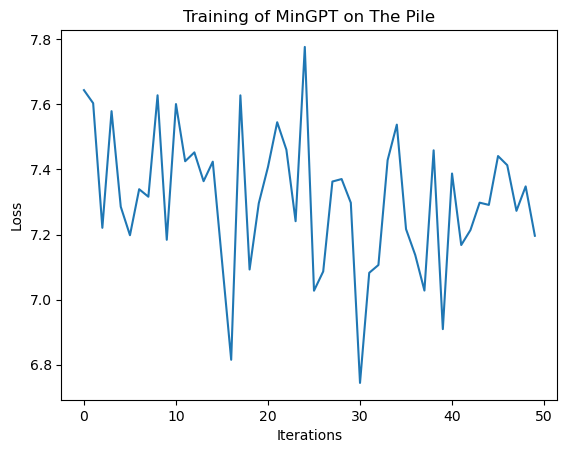

In [37]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

# Plot the loss
losses = trainer.curr_loss
x = 10
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)

plt.plot(np.arange(len(new_losses)), new_losses)
plt.title('Training of MinGPT on The Pile')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('mingpt_loss.png')

In [31]:
def calculate_means_numpy(input_list, x):
    input_array = np.array(input_list)
    result = np.mean(input_array.reshape(-1, x), axis=1)
    # print(input_array.reshape(-1, x))

    return result.tolist()

# Example usage:
original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
x = 2
result_list = calculate_means_numpy(original_list, x)

print(result_list)

a = np.array([1,2,3,4,5,5])
a.reshape(-1, 2)
a

[1.5, 3.5, 5.5, 7.5, 9.5, 11.5]


array([1, 2, 3, 4, 5, 5])

In [22]:
device = 'cpu'
model_type = 'gpt-mini'
def generate(prompt='', num_samples=10, steps=20, do_sample=True):
        
    # tokenize the input prompt into integer input sequence
    tokenizer = GPT2Tokenizer.from_pretrained(model_type)
    if prompt == '': 
        # to create unconditional samples...
        # huggingface/transformers tokenizer special cases these strings
        prompt = '<|endoftext|>'
    encoded_input = tokenizer(prompt, return_tensors='pt').to(device)
    x = encoded_input['input_ids']
    
    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)
    
    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())
        print('-'*80)
        print(out)
        

In [23]:
generate(prompt='Dylan Skinner is the', num_samples=10, steps=20)

OSError: gpt-mini is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

(choose from 'Ceval-valid-accountant', 'Ceval-valid-advanced_mathematics', 'Ceval-valid-art_studies', 'Ceval-valid-basic_medicine', 'Ceval-valid-business_administration', 'Ceval-valid-chinese_language_and_literature', 'Ceval-valid-civil_servant', 'Ceval-valid-clinical_medicine', 'Ceval-valid-college_chemistry', 'Ceval-valid-college_economics', 'Ceval-valid-college_physics', 'Ceval-valid-college_programming', 'Ceval-valid-computer_architecture', 'Ceval-valid-computer_network', 'Ceval-valid-discrete_mathematics', 'Ceval-valid-education_science', 'Ceval-valid-electrical_engineer', 'Ceval-valid-environmental_impact_assessment_engineer', 'Ceval-valid-fire_engineer', 'Ceval-valid-high_school_biology', 'Ceval-valid-high_school_chemistry', 'Ceval-valid-high_school_chinese', 'Ceval-valid-high_school_geography', 'Ceval-valid-high_school_history', 'Ceval-valid-high_school_mathematics', 'Ceval-valid-high_school_physics', 'Ceval-valid-high_school_politics', 'Ceval-valid-ideological_and_moral_cultivation', 'Ceval-valid-law', 'Ceval-valid-legal_professional', 'Ceval-valid-logic', 'Ceval-valid-mao_zedong_thought', 'Ceval-valid-marxism', 'Ceval-valid-metrology_engineer', 'Ceval-valid-middle_school_biology', 'Ceval-valid-middle_school_chemistry', 'Ceval-valid-middle_school_geography', 'Ceval-valid-middle_school_history', 'Ceval-valid-middle_school_mathematics', 'Ceval-valid-middle_school_physics', 'Ceval-valid-middle_school_politics', 'Ceval-valid-modern_chinese_history', 'Ceval-valid-operating_system', 'Ceval-valid-physician', 'Ceval-valid-plant_protection', 'Ceval-valid-probability_and_statistics', 'Ceval-valid-professional_tour_guide', 'Ceval-valid-sports_science', 'Ceval-valid-tax_accountant', 'Ceval-valid-teacher_qualification', 'Ceval-valid-urban_and_rural_planner', 'Ceval-valid-veterinary_medicine', 'anagrams1', 'anagrams2', 'anli_r1', 'anli_r2', 'anli_r3', 'arc_challenge', 'arc_easy', 'arithmetic_1dc', 'arithmetic_2da', 'arithmetic_2dm', 'arithmetic_2ds', 'arithmetic_3da', 'arithmetic_3ds', 'arithmetic_4da', 'arithmetic_4ds', 'arithmetic_5da', 'arithmetic_5ds', 'babi', 'bigbench___init__', 'bigbench_causal_judgement', 'bigbench_date_understanding', 'bigbench_disambiguation_qa', 'bigbench_dyck_languages', 'bigbench_formal_fallacies_syllogisms_negation', 'bigbench_geometric_shapes', 'bigbench_hyperbaton', 'bigbench_logical_deduction_five_objects', 'bigbench_logical_deduction_seven_objects', 'bigbench_logical_deduction_three_objects', 'bigbench_movie_recommendation', 'bigbench_navigate', 'bigbench_reasoning_about_colored_objects', 'bigbench_ruin_names', 'bigbench_salient_translation_error_detection', 'bigbench_snarks', 'bigbench_sports_understanding', 'bigbench_temporal_sequences', 'bigbench_tracking_shuffled_objects_five_objects', 'bigbench_tracking_shuffled_objects_seven_objects', 'bigbench_tracking_shuffled_objects_three_objects', 'blimp_adjunct_island', 'blimp_anaphor_gender_agreement', 'blimp_anaphor_number_agreement', 'blimp_animate_subject_passive', 'blimp_animate_subject_trans', 'blimp_causative', 'blimp_complex_NP_island', 'blimp_coordinate_structure_constraint_complex_left_branch', 'blimp_coordinate_structure_constraint_object_extraction', 'blimp_determiner_noun_agreement_1', 'blimp_determiner_noun_agreement_2', 'blimp_determiner_noun_agreement_irregular_1', 'blimp_determiner_noun_agreement_irregular_2', 'blimp_determiner_noun_agreement_with_adj_2', 'blimp_determiner_noun_agreement_with_adj_irregular_1', 'blimp_determiner_noun_agreement_with_adj_irregular_2', 'blimp_determiner_noun_agreement_with_adjective_1', 'blimp_distractor_agreement_relational_noun', 'blimp_distractor_agreement_relative_clause', 'blimp_drop_argument', 'blimp_ellipsis_n_bar_1', 'blimp_ellipsis_n_bar_2', 'blimp_existential_there_object_raising', 'blimp_existential_there_quantifiers_1', 'blimp_existential_there_quantifiers_2', 'blimp_existential_there_subject_raising', 'blimp_expletive_it_object_raising', 'blimp_inchoative', 'blimp_intransitive', 'blimp_irregular_past_participle_adjectives', 'blimp_irregular_past_participle_verbs', 'blimp_irregular_plural_subject_verb_agreement_1', 'blimp_irregular_plural_subject_verb_agreement_2', 'blimp_left_branch_island_echo_question', 'blimp_left_branch_island_simple_question', 'blimp_matrix_question_npi_licensor_present', 'blimp_npi_present_1', 'blimp_npi_present_2', 'blimp_only_npi_licensor_present', 'blimp_only_npi_scope', 'blimp_passive_1', 'blimp_passive_2', 'blimp_principle_A_c_command', 'blimp_principle_A_case_1', 'blimp_principle_A_case_2', 'blimp_principle_A_domain_1', 'blimp_principle_A_domain_2', 'blimp_principle_A_domain_3', 'blimp_principle_A_reconstruction', 'blimp_regular_plural_subject_verb_agreement_1', 'blimp_regular_plural_subject_verb_agreement_2', 'blimp_sentential_negation_npi_licensor_present', 'blimp_sentential_negation_npi_scope', 'blimp_sentential_subject_island', 'blimp_superlative_quantifiers_1', 'blimp_superlative_quantifiers_2', 'blimp_tough_vs_raising_1', 'blimp_tough_vs_raising_2', 'blimp_transitive', 'blimp_wh_island', 'blimp_wh_questions_object_gap', 'blimp_wh_questions_subject_gap', 'blimp_wh_questions_subject_gap_long_distance', 'blimp_wh_vs_that_no_gap', 'blimp_wh_vs_that_no_gap_long_distance', 'blimp_wh_vs_that_with_gap', 'blimp_wh_vs_that_with_gap_long_distance', 'boolq', 'cb', 'cmmlu-agronomy', 'cmmlu-anatomy', 'cmmlu-ancient_chinese', 'cmmlu-arts', 'cmmlu-astronomy', 'cmmlu-business_ethics', 'cmmlu-chinese_civil_service_exam', 'cmmlu-chinese_driving_rule', 'cmmlu-chinese_food_culture', 'cmmlu-chinese_foreign_policy', 'cmmlu-chinese_history', 'cmmlu-chinese_literature', 'cmmlu-chinese_teacher_qualification', 'cmmlu-clinical_knowledge', 'cmmlu-college_actuarial_science', 'cmmlu-college_education', 'cmmlu-college_engineering_hydrology', 'cmmlu-college_law', 'cmmlu-college_mathematics', 'cmmlu-college_medical_statistics', 'cmmlu-college_medicine', 'cmmlu-computer_science', 'cmmlu-computer_security', 'cmmlu-conceptual_physics', 'cmmlu-construction_project_management', 'cmmlu-economics', 'cmmlu-education', 'cmmlu-electrical_engineering', 'cmmlu-elementary_chinese', 'cmmlu-elementary_commonsense', 'cmmlu-elementary_information_and_technology', 'cmmlu-elementary_mathematics', 'cmmlu-ethnology', 'cmmlu-food_science', 'cmmlu-genetics', 'cmmlu-global_facts', 'cmmlu-high_school_biology', 'cmmlu-high_school_chemistry', 'cmmlu-high_school_geography', 'cmmlu-high_school_mathematics', 'cmmlu-high_school_physics', 'cmmlu-high_school_politics', 'cmmlu-human_sexuality', 'cmmlu-international_law', 'cmmlu-journalism', 'cmmlu-jurisprudence', 'cmmlu-legal_and_moral_basis', 'cmmlu-logical', 'cmmlu-machine_learning', 'cmmlu-management', 'cmmlu-marketing', 'cmmlu-marxist_theory', 'cmmlu-modern_chinese', 'cmmlu-nutrition', 'cmmlu-philosophy', 'cmmlu-professional_accounting', 'cmmlu-professional_law', 'cmmlu-professional_medicine', 'cmmlu-professional_psychology', 'cmmlu-public_relations', 'cmmlu-security_study', 'cmmlu-sociology', 'cmmlu-sports_science', 'cmmlu-traditional_chinese_medicine', 'cmmlu-virology', 'cmmlu-world_history', 'cmmlu-world_religions', 'cola', 'copa', 'coqa', 'crows_pairs_english', 'crows_pairs_english_age', 'crows_pairs_english_autre', 'crows_pairs_english_disability', 'crows_pairs_english_gender', 'crows_pairs_english_nationality', 'crows_pairs_english_physical_appearance', 'crows_pairs_english_race_color', 'crows_pairs_english_religion', 'crows_pairs_english_sexual_orientation', 'crows_pairs_english_socioeconomic', 'crows_pairs_french', 'crows_pairs_french_age', 'crows_pairs_french_autre', 'crows_pairs_french_disability', 'crows_pairs_french_gender', 'crows_pairs_french_nationality', 'crows_pairs_french_physical_appearance', 'crows_pairs_french_race_color', 'crows_pairs_french_religion', 'crows_pairs_french_sexual_orientation', 'crows_pairs_french_socioeconomic', 'csatqa_gr', 'csatqa_li', 'csatqa_rch', 'csatqa_rcs', 'csatqa_rcss', 'csatqa_wr', 'cycle_letters', 'drop', 'ethics_cm', 'ethics_deontology', 'ethics_justice', 'ethics_utilitarianism', 'ethics_utilitarianism_original', 'ethics_virtue', 'gsm8k', 'haerae_hi', 'haerae_kgk', 'haerae_lw', 'haerae_rc', 'haerae_rw', 'haerae_sn', 'headqa', 'headqa_en', 'headqa_es', 'hellaswag', 'hendrycksTest-abstract_algebra', 'hendrycksTest-anatomy', 'hendrycksTest-astronomy', 'hendrycksTest-business_ethics', 'hendrycksTest-clinical_knowledge', 'hendrycksTest-college_biology', 'hendrycksTest-college_chemistry', 'hendrycksTest-college_computer_science', 'hendrycksTest-college_mathematics', 'hendrycksTest-college_medicine', 'hendrycksTest-college_physics', 'hendrycksTest-computer_security', 'hendrycksTest-conceptual_physics', 'hendrycksTest-econometrics', 'hendrycksTest-electrical_engineering', 'hendrycksTest-elementary_mathematics', 'hendrycksTest-formal_logic', 'hendrycksTest-global_facts', 'hendrycksTest-high_school_biology', 'hendrycksTest-high_school_chemistry', 'hendrycksTest-high_school_computer_science', 'hendrycksTest-high_school_european_history', 'hendrycksTest-high_school_geography', 'hendrycksTest-high_school_government_and_politics', 'hendrycksTest-high_school_macroeconomics', 'hendrycksTest-high_school_mathematics', 'hendrycksTest-high_school_microeconomics', 'hendrycksTest-high_school_physics', 'hendrycksTest-high_school_psychology', 'hendrycksTest-high_school_statistics', 'hendrycksTest-high_school_us_history', 'hendrycksTest-high_school_world_history', 'hendrycksTest-human_aging', 'hendrycksTest-human_sexuality', 'hendrycksTest-international_law', 'hendrycksTest-jurisprudence', 'hendrycksTest-logical_fallacies', 'hendrycksTest-machine_learning', 'hendrycksTest-management', 'hendrycksTest-marketing', 'hendrycksTest-medical_genetics', 'hendrycksTest-miscellaneous', 'hendrycksTest-moral_disputes', 'hendrycksTest-moral_scenarios', 'hendrycksTest-nutrition', 'hendrycksTest-philosophy', 'hendrycksTest-prehistory', 'hendrycksTest-professional_accounting', 'hendrycksTest-professional_law', 'hendrycksTest-professional_medicine', 'hendrycksTest-professional_psychology', 'hendrycksTest-public_relations', 'hendrycksTest-security_studies', 'hendrycksTest-sociology', 'hendrycksTest-us_foreign_policy', 'hendrycksTest-virology', 'hendrycksTest-world_religions', 'iwslt17-ar-en', 'iwslt17-en-ar', 'lambada_openai', 'lambada_openai_cloze', 'lambada_openai_mt_de', 'lambada_openai_mt_en', 'lambada_openai_mt_es', 'lambada_openai_mt_fr', 'lambada_openai_mt_it', 'lambada_standard', 'lambada_standard_cloze', 'logiqa', 'math_algebra', 'math_asdiv', 'math_counting_and_prob', 'math_geometry', 'math_intermediate_algebra', 'math_num_theory', 'math_prealgebra', 'math_precalc', 'mathqa', 'mc_taco', 'mgsm_bn', 'mgsm_de', 'mgsm_en', 'mgsm_es', 'mgsm_fr', 'mgsm_ja', 'mgsm_ru', 'mgsm_sw', 'mgsm_te', 'mgsm_th', 'mgsm_zh', 'mnli', 'mnli_mismatched', 'mrpc', 'multirc', 'mutual', 'mutual_plus', 'nq_open', 'openbookqa', 'pawsx_de', 'pawsx_en', 'pawsx_es', 'pawsx_fr', 'pawsx_ja', 'pawsx_ko', 'pawsx_zh', 'pile_arxiv', 'pile_bookcorpus2', 'pile_books3', 'pile_dm-mathematics', 'pile_enron', 'pile_europarl', 'pile_freelaw', 'pile_github', 'pile_gutenberg', 'pile_hackernews', 'pile_nih-exporter', 'pile_opensubtitles', 'pile_openwebtext2', 'pile_philpapers', 'pile_pile-cc', 'pile_pubmed-abstracts', 'pile_pubmed-central', 'pile_stackexchange', 'pile_ubuntu-irc', 'pile_uspto', 'pile_wikipedia', 'pile_youtubesubtitles', 'piqa', 'prost', 'pubmedqa', 'qa4mre_2011', 'qa4mre_2012', 'qa4mre_2013', 'qasper', 'qnli', 'qqp', 'race', 'random_insertion', 'record', 'reversed_words', 'rte', 'sciq', 'scrolls_contractnli', 'scrolls_govreport', 'scrolls_narrativeqa', 'scrolls_qasper', 'scrolls_qmsum', 'scrolls_quality', 'scrolls_summscreenfd', 'squad2', 'sst', 'swag', 'toxigen', 'triviaqa', 'truthfulqa_gen', 'truthfulqa_mc', 'webqs', 'wic', 'wikitext', 'winogrande', 'wmt14-en-fr', 'wmt14-fr-en', 'wmt16-de-en', 'wmt16-en-de', 'wmt16-en-ro', 'wmt16-ro-en', 'wmt20-cs-en', 'wmt20-de-en', 'wmt20-de-fr', 'wmt20-en-cs', 'wmt20-en-de', 'wmt20-en-iu', 'wmt20-en-ja', 'wmt20-en-km', 'wmt20-en-pl', 'wmt20-en-ps', 'wmt20-en-ru', 'wmt20-en-ta', 'wmt20-en-zh', 'wmt20-fr-de', 'wmt20-iu-en', 'wmt20-ja-en', 'wmt20-km-en', 'wmt20-pl-en', 'wmt20-ps-en', 'wmt20-ru-en', 'wmt20-ta-en', 'wmt20-zh-en', 'wnli', 'wsc', 'wsc273', 'xcopa_et', 'xcopa_ht', 'xcopa_id', 'xcopa_it', 'xcopa_qu', 'xcopa_sw', 'xcopa_ta', 'xcopa_th', 'xcopa_tr', 'xcopa_vi', 'xcopa_zh', 'xnli_ar', 'xnli_bg', 'xnli_de', 'xnli_el', 'xnli_en', 'xnli_es', 'xnli_fr', 'xnli_hi', 'xnli_ru', 'xnli_sw', 'xnli_th', 'xnli_tr', 'xnli_ur', 'xnli_vi', 'xnli_zh', 'xstory_cloze_ar', 'xstory_cloze_en', 'xstory_cloze_es', 'xstory_cloze_eu', 'xstory_cloze_hi', 'xstory_cloze_id', 'xstory_cloze_my', 'xstory_cloze_ru', 'xstory_cloze_sw', 'xstory_cloze_te', 'xstory_cloze_zh', 'xwinograd_en', 'xwinograd_fr', 'xwinograd_jp', 'xwinograd_pt', 'xwinograd_ru', 'xwinograd_zh')